In [16]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%run nlp_topic_utils.ipynb

#添加文件地址
file_path = 'C:\\Users\\Asus\\nmf\\'
file_name = 'topic_cleaned_data.csv'

#读取excel文件
#读入5000行数据
df = pd.read_csv(file_path + file_name,nrows=5000)

df=df.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1)

print(df.shape)
df.head()


(5000, 11)


,Title,Abstract,Source,PubDate,Journal,DOI,FirstAuthor,OtherAuthors,Keywords,TextBody,Languages
0,The RNA pseudoknots in foot-and-mouth disease ...,word count text word count right reserved reus...,biorxiv,2020-01-11,NaN,10.1101/2020.01.10.901801,Joseph C. Ward,Lidia Lasecka-Dykes; Chris Neil; Oluwapelum...,NaN,vp vp processed vp vp virus assembly p p regio...,en
1,Regaining perspective on SARS-CoV-2 molecular ...,past three month new coronavirus sarscov epide...,medrxiv,2020-03-20,medRxiv,10.1101/2020.03.16.20034470,Carla Mavian,Simone Marini; Costanza Manes; Ilaria Capua...,NaN,december novel coronavirus sarscov identified ...,en
2,Relationship between Average Daily Temperature...,rapid outbreak new coronavirus pandemic spread...,medrxiv,2020-04-14,NaN,10.1101/2020.04.10.20059337,Behzad Pirouz,Amirsina Golmohammadi; Hasti Saeidpour Masou...,NaN,outbreak infectious disease always one importa...,en
3,CHEER: hierarCHical taxonomic classification f...,fast accumulation viral metagenomic data contr...,biorxiv,2020-03-27,NaN,10.1101/2020.03.26.009001,Jiayu Shang. Yanni Sun,NaN,NaN,metagenomic sequencing allows u directly obtai...,en
4,Impact of COVID-19 pandemic on severity of ill...,objective describe change patient population b...,medrxiv,2020-04-14,NaN,10.1101/2020.04.08.20058180,Omar Badawi,Xinggang Liu; Iris Berman; Pamela J Amelung...,NaN,since emergence december novel coronavirus sar...,en


In [17]:
#处理文本
df['processed_text'] = df['TextBody'].apply(process_text)


In [18]:

# 获取单词数
df['word_count'] = df['TextBody'].apply(word_count)
df['word_count'].mean()
# 字计数的描述性统计
df['word_count'].describe()

count     5000.00000
mean      2327.39600
std       1570.81566
min          9.00000
25%       1368.00000
50%       2082.00000
75%       2982.25000
max      44010.00000
Name: word_count, dtype: float64

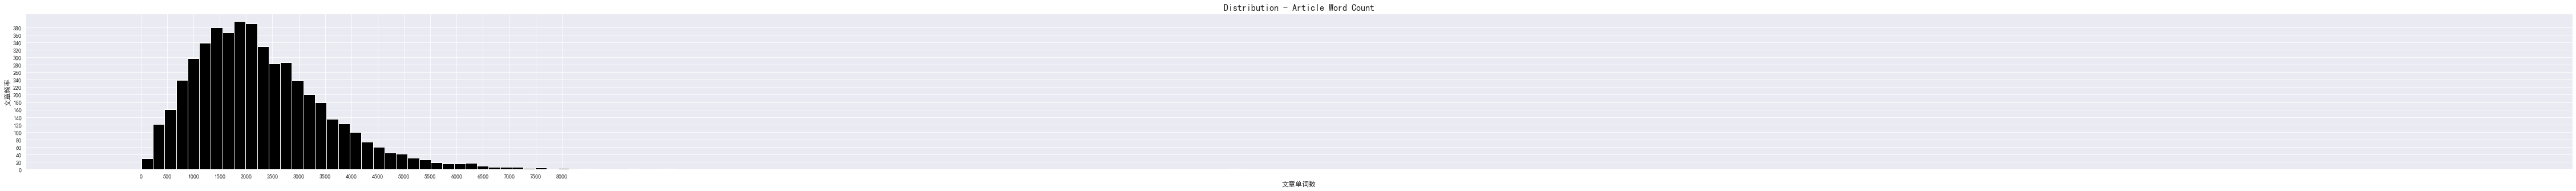

In [19]:

#显示中文不会乱码
import matplotlib.pyplot as plt  
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 绘制一个单词计数的hist
fig = plt.figure(figsize=(80,5))

plt.hist(
    df['word_count'],
    bins=200,
    color='#000000'
)

plt.title('Distribution - Article Word Count', fontsize=16)
plt.ylabel('文章频率', fontsize=12)
plt.xlabel('文章单词数', fontsize=12)
plt.yticks(np.arange(0, 400, 20))
plt.xticks(np.arange(0, 8500, 500))

file_name = 'hist'

fig.savefig(
    file_path + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

In [20]:

#找出所有文章中最常见的20个单词
p_text = df['processed_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),  #找出序列中出现次数最多的元素,n表示前n个出现次数最多的元素
    columns=['词', '频率']   #行名
)

top_20

,词,频率
0,cell,109743
1,infect,91653
2,virus,80414
3,studi,62626
4,protein,62430
5,viral,41637
6,data,41308
7,figur,40870
8,patient,40326
9,result,40235


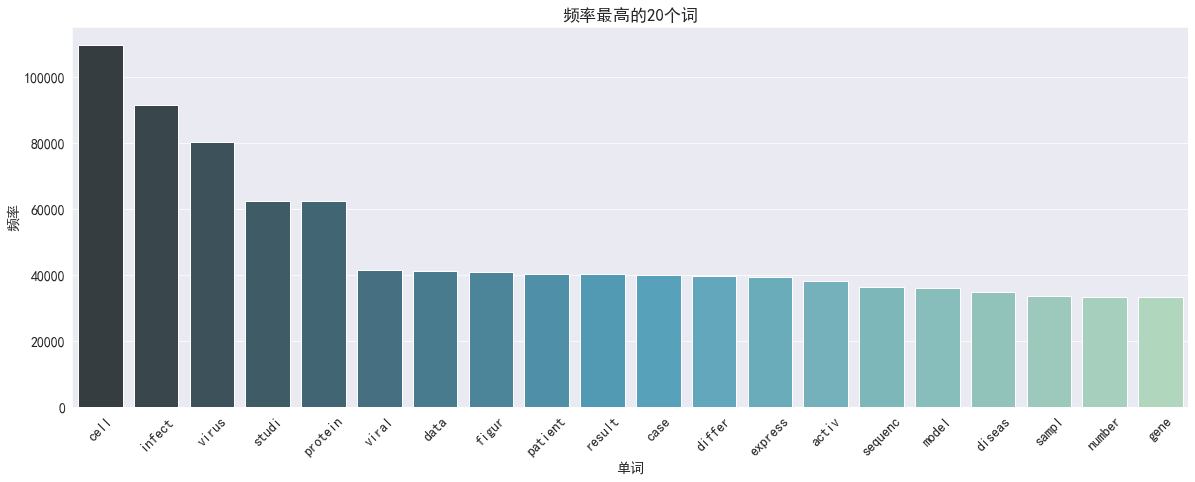

In [21]:

# 用条形图标出20个最常出现的单词
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='词',
    y='频率',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('单词', fontsize=14)
plt.ylabel('频率', fontsize=14)
plt.title('频率最高的20个词', fontsize=17)

file_name = 'top_words'

fig.savefig(
    file_path + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

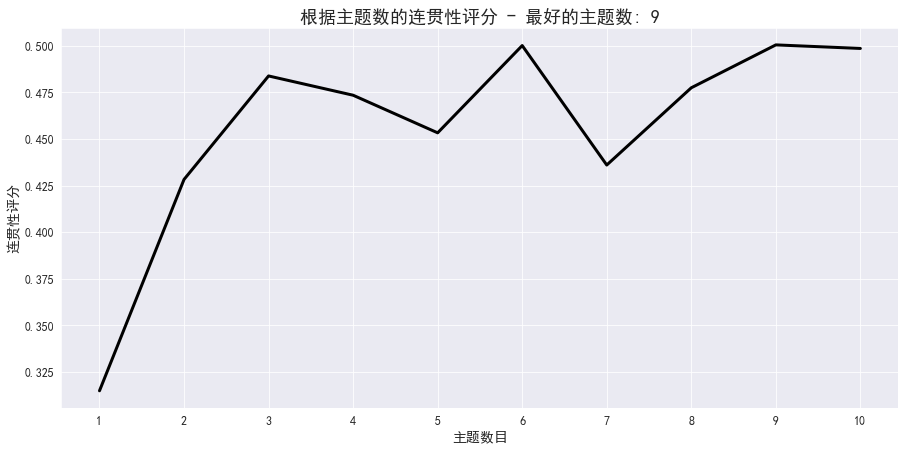

In [22]:

# 使用 NMF，通过连贯性得分得到最好的主题数量
texts = df['processed_text']

#创建字典
#在gensim中，字典是单词及其整数id之间的映射
dictionary = Dictionary(texts)

# 过滤极端情况以限制功能的数量
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

#创建单词袋格式((token_id, token_count)的列表)
corpus = [dictionary.doc2bow(text) for text in texts]

# 创建一个我们想要尝试的主题编号的列表
topic_nums = list(np.arange(1,10 + 1, 1))

#运行nmf模型，计算连贯性得分
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # 运行连贯性模型来得到分数
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# 获得连贯性得分最高的主题数
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# 结果展示
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#000000'
)

plt.xlabel("主题数目", fontsize=14)
plt.ylabel("连贯性评分", fontsize=14)
plt.title('根据主题数的连贯性评分 - 最好的主题数: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(1, max(topic_nums) + 1, 1), fontsize=12)


plt.yticks(fontsize=12)

file_name = 'c_score'

fig.savefig(
    file_path + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

In [23]:
#现在使用主题的数量与
#最高的连贯性得分
# sklearn nmf模型

texts = df['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

#保存特性名称，以便稍后创建主题摘要
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

In [24]:
#使用tfidf权重为每个聚类的顶部词
#创建“主题”
#通过文档获取每个主题的df

docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 3

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

#清理顶部的单词，创建主题摘要
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # 把每个单词组成一个列表
topic_df['topics'] = topic_df['topics'].str[0]                      # 删除列表括号
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # 标记字符串

topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # 删除重复的单词
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # 把每个单词组成一个列表
topic_df['topics'] = topic_df['topics'].str[0]  # 删除列表括号

topic_df.head(n=9)

,0,1,2,topics
0,cell,express,activ,cell express activ
1,case,model,avail display,case model avail display
2,patient,hospit,pneumonia,patient hospit pneumonia
3,sequenc,virus,genom,sequenc virus genom
4,reserv reus,reus allow,allow permiss,reserv reus allow permiss
5,protein,sarscov,bind,protein sarscov bind
6,health,diseas,public,health diseas public
7,vaccin,mous,immun,vaccin mous immun
8,bat,merscov,virus,bat merscov virus


In [27]:
# 创建一个df，只包含已创建的主题和主题编号
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head(n=9)

,topic_num,topics
0,0,cell express activ
1,1,case model avail display
2,2,patient hospit pneumonia
3,3,sequenc virus genom
4,4,reserv reus allow permiss
5,5,protein sarscov bind
6,6,health diseas public
7,7,vaccin mous immun
8,8,bat merscov virus


In [28]:
# 使要加入的主题num创建一个临时df
Title = df['Title'].tolist()

df_temp = pd.DataFrame({
    'Title': Title,
    'topic_num': docweights.argmax(axis=1)
})

#合并
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# 与原始df合并
df_topics = pd.merge(
    df,
    merged_topic,
    on='Title',
    how='left'
)

df_topics = df_topics.drop(
    'processed_text',
    axis=1
)

df_topics.head()

,Title,Abstract,Source,PubDate,Journal,DOI,FirstAuthor,OtherAuthors,Keywords,TextBody,Languages,word_count,topic_num,topics
0,The RNA pseudoknots in foot-and-mouth disease ...,word count text word count right reserved reus...,biorxiv,2020-01-11,NaN,10.1101/2020.01.10.901801,Joseph C. Ward,Lidia Lasecka-Dykes; Chris Neil; Oluwapelum...,NaN,vp vp processed vp vp virus assembly p p regio...,en,846,4,reserv reus allow permiss
1,Regaining perspective on SARS-CoV-2 molecular ...,past three month new coronavirus sarscov epide...,medrxiv,2020-03-20,medRxiv,10.1101/2020.03.16.20034470,Carla Mavian,Simone Marini; Costanza Manes; Ilaria Capua...,NaN,december novel coronavirus sarscov identified ...,en,1357,1,case model avail display
2,Relationship between Average Daily Temperature...,rapid outbreak new coronavirus pandemic spread...,medrxiv,2020-04-14,NaN,10.1101/2020.04.10.20059337,Behzad Pirouz,Amirsina Golmohammadi; Hasti Saeidpour Masou...,NaN,outbreak infectious disease always one importa...,en,1380,1,case model avail display
3,CHEER: hierarCHical taxonomic classification f...,fast accumulation viral metagenomic data contr...,biorxiv,2020-03-27,NaN,10.1101/2020.03.26.009001,Jiayu Shang. Yanni Sun,NaN,NaN,metagenomic sequencing allows u directly obtai...,en,2889,3,sequenc virus genom
4,Impact of COVID-19 pandemic on severity of ill...,objective describe change patient population b...,medrxiv,2020-04-14,NaN,10.1101/2020.04.08.20058180,Omar Badawi,Xinggang Liu; Iris Berman; Pamela J Amelung...,NaN,since emergence december novel coronavirus sar...,en,747,2,patient hospit pneumonia


In [33]:

# 展示了我们在nmf中得到的三个矩阵
V = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(V)

print('V = {} x {}'.format(V.shape[0], V.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))
r = np.zeros(V.shape[0])

for row in range(V.shape[0]):
    r[row] = np.linalg.norm(V[row, :] - H[row, :].dot(W), 'fro')

sum_sqrt_res = round(sum(np.sqrt(r)), 3)
'残差平方和是{}'.format(sum_sqrt_res)

V = 5000 x 5000
W = 9 x 5000
H = 5000 x 9


'残差平方和是4762.661'

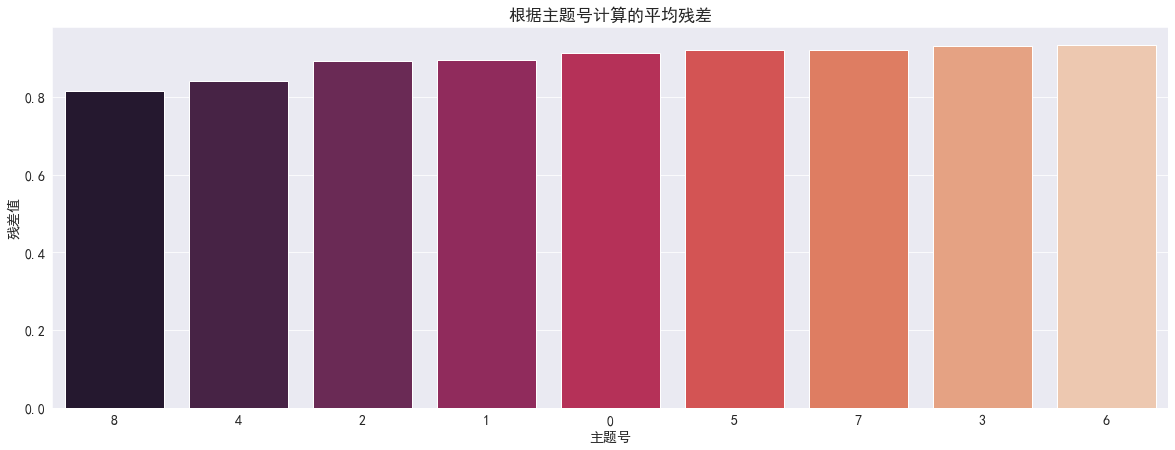

In [34]:
# 把余数加到df上
df_topics['resid'] = r

#通过主题得到平均残差
resid_data = df_topics[[
    'topic_num',
    'resid'
]].groupby('topic_num').mean().sort_values(by='resid')

# 绘制一个柱状图的平均残差按主题
fig = plt.figure(figsize=(20,7))

x = resid_data.index
y = resid_data['resid']
    
g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='rocket'
)

g.set_xticklabels(
    g.get_xticklabels(),
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('主题号', fontsize=14)
plt.ylabel('残差值', fontsize=14)
plt.title('根据主题号计算的平均残差', fontsize=17)

file_name = 'avg_resid'

fig.savefig(
    file_path + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

In [38]:

# 对新的文章进行预测
file_name = 'topic_cleaned_data.csv'
df_new = pd.read_csv(file_path + file_name,nrows=5800)
df_new=df_new.loc[5555:5560]

#处理文本
df_new['processed_text'] = df_new['TextBody'].apply(process_text)

new_texts = df_new['processed_text']

# 使用拟合模型转换新数据
tfidf_new = tfidf_vectorizer.transform(new_texts)
X_new = nmf.transform(tfidf_new)

#获得最热门的预测话题
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]

# 增加df
df_new['pred_topic_num'] = predicted_topics

df_new

,Title,Abstract,FirstAuthor,OtherAuthors,TextBody,processed_text,pred_topic_num
5555,Crude incidence in two-phase designs in the pr...,background many study information might availa...,"Rebora, Paola","Antolini, Laura; Glidden, David V.; Valsecc...",many longitudinal study information might meas...,"[mani, longitudin, studi, inform, measuredavai...",1
5556,Analysis of the spleen proteome of chickens in...,infection reticuloendotheliosis virus rev gamm...,"Xue, Mei","Zhao, Yan; Hu, Shunlei; Shi, Xingming; Cui...",reticuloendotheliosis virus rev group virus fa...,"[reticuloendotheliosi, virus, rev, group, viru...",5
5557,Hepatitis C Virus Entry: An Intriguingly Compl...,hepatitis c virus hcv major cause chronic hepa...,"Colpitts, Che C.","Tsai, Pei-Ling; Zeisel, Mirjam B.",recent estimate world health organization indi...,"[recent, estim, world, health, organ, indic, a...",5
5558,Comparison of loop-mediated isothermal amplifi...,background tuberculosis tb caused mycobacteriu...,"Gelaw, Baye","Shiferaw, Yitayal; Alemayehu, Marta; Bashaw...",tuberculosis tb caused mycobacterium tuberculo...,"[tuberculosi, tb, caus, mycobacterium, tubercu...",3
5559,Genetic and antigenic characterization of reco...,characterize antigenicity nucleocapsid protein...,"Lu, Shuai","Chen, Yingzhu; Qin, Kun; Zhou, Jianfang; L...",coronaviruses enveloped positivestranded rna v...,"[coronavirus, envelop, positivestrand, rna, vi...",5
5560,No MERS-CoV but positive influenza viruses in ...,background global health concern mass movement...,"Ma, Xuezheng","Liu, Fang; Liu, Lijuan; Zhang, Liping; Lu,...",november laboratoryconfirmed case middle east ...,"[novemb, laboratoryconfirm, case, middl, east,...",6
